In [433]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
from itertools import product
from itertools import combinations
from scipy.stats import chi2_contingency
# Otros objetivos
# -----------------------------------------------------------------------
import math
# Funciones
import sys
sys.path.append('../') #pongo los 2 puntos para que salga de la carpeta
import src.funciones as f
import src.soporte_prep as spp

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Nulos 
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Estandarización
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler

# Encoding
from category_encoders import TargetEncoder

# Para tratar el problema de desbalance
# -----------------------------------------------------------------------
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Outliers
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors 

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [434]:
df_general = pd.read_csv('../datos/general_data.csv')
df_employee_survey = pd.read_csv('../datos/employee_survey_data.csv')
df_manager_survey = pd.read_csv('../datos/manager_survey_data.csv')

# EDA

## Data frame general

In [435]:
df_general.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4


In [436]:
df_general.shape

(4410, 24)

In [437]:
df_general.nunique()

Age                          43
Attrition                     2
BusinessTravel                3
Department                    3
DistanceFromHome             29
Education                     5
EducationField                6
EmployeeCount                 1
EmployeeID                 4410
Gender                        2
JobLevel                      5
JobRole                       9
MaritalStatus                 3
MonthlyIncome              1349
NumCompaniesWorked           10
Over18                        1
PercentSalaryHike            15
StandardHours                 1
StockOptionLevel              4
TotalWorkingYears            40
TrainingTimesLastYear         7
YearsAtCompany               37
YearsSinceLastPromotion      16
YearsWithCurrManager         18
dtype: int64

De esta forma, puedo comprobar las categorías en las variables del mismo tipo.

In [438]:
df_general.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

Aquí voy observando los nulos que tengo en mis datos, señalando que solo tengo nulos en una columna: NumCompaniesWorked (19 nulos).

## Datos de la encuesta a empleados

In [439]:
df_employee_survey.head()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0


In [441]:
df_employee_survey.nunique()

EmployeeID                 4410
EnvironmentSatisfaction       4
JobSatisfaction               4
WorkLifeBalance               4
dtype: int64

In [442]:
df_employee_survey.isna().sum()

EmployeeID                  0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64

En la encuesta realizada a los empleados, puedo observar que tengo nulos en todas las variables que hacen referencia a las preguntas de la encuesta. Sin embargo, no tengo nulos en el EmployeeID lo que me indica buena señal.

## Datos de la encuesta realizada a los managers

In [443]:
df_manager_survey.head()

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3


In [444]:
df_manager_survey.nunique()

EmployeeID           4410
JobInvolvement          4
PerformanceRating       2
dtype: int64

In [445]:
df_manager_survey.isna().sum()

EmployeeID           0
JobInvolvement       0
PerformanceRating    0
dtype: int64

En la encuesta realizada a los managers, no tengo nulos en ningún lugar.

## Mergeo

In [446]:
df_mergeo = df_general.merge(df_employee_survey, on='EmployeeID', how='inner') \
               .merge(df_manager_survey, on='EmployeeID', how='inner')

In [447]:
df_mergeo.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3


In [448]:
df_mergeo.to_csv('../datos/df_completo.csv')

In [449]:
df_mergeo.shape

(4410, 29)

In [450]:
df_mergeo.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
JobInvolvement              0
PerformanceRating           0
dtype: int64

He identificado que tengo 4 columnas con nulo, más adelante veo qué puedo hacer.

In [451]:
df_mergeo[pd.isnull(df_mergeo['NumCompaniesWorked'])]

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
115,27,No,Travel_Rarely,Sales,2,3,Life Sciences,1,116,Male,1,Sales Executive,Divorced,23670,NaN,Y,12,8,1,5.0,2,5,0,4,4.0,2.0,3.0,3,3
210,52,No,Travel_Rarely,Sales,2,1,Medical,1,211,Male,1,Laboratory Technician,Divorced,99800,NaN,Y,11,8,1,18.0,2,10,6,9,4.0,1.0,3.0,3,3
343,40,No,Travel_Frequently,Sales,9,3,Marketing,1,344,Male,3,Manufacturing Director,Single,22380,NaN,Y,14,8,0,10.0,3,1,0,0,1.0,3.0,3.0,3,3
476,22,No,Travel_Rarely,Research & Development,8,3,Other,1,477,Male,2,Sales Representative,Married,49070,NaN,Y,21,8,1,4.0,2,4,1,1,2.0,1.0,2.0,3,4
647,29,No,Travel_Rarely,Research & Development,3,3,Technical Degree,1,648,Female,2,Healthcare Representative,Divorced,48050,NaN,Y,16,8,1,9.0,2,7,1,7,4.0,4.0,2.0,3,3
799,29,Yes,Travel_Frequently,Research & Development,28,3,Medical,1,800,Female,5,Research Scientist,Single,44340,NaN,Y,17,8,3,7.0,1,5,0,0,1.0,2.0,1.0,3,3
932,32,No,Travel_Rarely,Research & Development,5,4,Technical Degree,1,933,Male,5,Research Scientist,Divorced,50030,NaN,Y,13,8,0,10.0,5,9,1,6,4.0,2.0,2.0,3,3
1103,26,No,Travel_Frequently,Sales,16,2,Life Sciences,1,1104,Male,2,Healthcare Representative,Married,83800,NaN,Y,14,8,0,8.0,3,7,7,7,3.0,4.0,3.0,4,3
1312,37,Yes,Travel_Rarely,Human Resources,9,3,Human Resources,1,1313,Male,2,Healthcare Representative,Divorced,54840,NaN,Y,17,8,0,7.0,4,3,0,2,3.0,1.0,3.0,3,3
1521,31,No,Travel_Rarely,Research & Development,20,1,Technical Degree,1,1522,Female,3,Research Scientist,Married,99070,NaN,Y,13,8,1,6.0,3,5,0,3,3.0,4.0,3.0,2,3


## Exploración

In [452]:
f.exploracion_dataframe(df_mergeo, 'Attrition')

El número de datos es 4410 y el de columnas es 29

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos
NumCompaniesWorked,0.430839
TotalWorkingYears,0.204082
EnvironmentSatisfaction,0.566893
JobSatisfaction,0.453515
WorkLifeBalance,0.861678



 ..................... 

Los tipos de las columnas son:


,tipo_dato
Age,int64
Attrition,object
BusinessTravel,object
Department,object
DistanceFromHome,int64
Education,int64
EducationField,object
EmployeeCount,int64
EmployeeID,int64
Gender,object



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna Attrition tiene los siguientes valores únicos:


,count
Attrition,
No,3699
Yes,711


La columna BusinessTravel tiene los siguientes valores únicos:


,count
BusinessTravel,
Travel_Rarely,3129
Travel_Frequently,831
Non-Travel,450


La columna Department tiene los siguientes valores únicos:


,count
Department,
Research & Development,2883
Sales,1338
Human Resources,189


La columna EducationField tiene los siguientes valores únicos:


,count
EducationField,
Life Sciences,1818
Medical,1392
Marketing,477
Technical Degree,396
Other,246
Human Resources,81


La columna Gender tiene los siguientes valores únicos:


,count
Gender,
Male,2646
Female,1764


La columna JobRole tiene los siguientes valores únicos:


,count
JobRole,
Sales Executive,978
Research Scientist,876
Laboratory Technician,777
Manufacturing Director,435
Healthcare Representative,393
Manager,306
Sales Representative,249
Research Director,240
Human Resources,156


La columna MaritalStatus tiene los siguientes valores únicos:


,count
MaritalStatus,
Married,2019
Single,1410
Divorced,981


La columna Over18 tiene los siguientes valores únicos:


,count
Over18,
Y,4410


### Observaciones:
- No tenemos duplicados, tenemos un conjunto de datos de 4,410 empleados con unas 29 columnas (luego de haber unido mis 3 conjuntos de datos).
- Hay nulos en 5 columnas.
- Existe desbalanceo en mi variable respuesta 'Attrition.
- Existen columnas numéricas que en realidad son categóricas, i.e. Education.
- Existen 2 columnas que no aportan datos: EmployeeCount (hace un conteo a uno de cada empleado) y over18(que confirma si el empleado tiene más de 18 años, cosa que queda reafirmada ya en una columna de Edad)

- En el último año se han ido de la empresa 711 personas (16%). 
- Tengo una población mayormente masculina (60%)
- En su mayoría son personas casadas, por encima de los solteros y divorciados (45%)
- Tengo una media de edad de 36 años, con una desviación estándar de 9 años.


In [453]:
df_mergeo.drop(columns=['Over18', 'EmployeeCount', 'StandardHours', 'EmployeeID'], inplace=True)

Estas columnas en sí no aportan nada, me las llevo.

In [454]:
df_mergeo.shape

(4410, 25)

Vamos a mappear mi columna Attrition, para ya dejar claro si se ha ido o no en el último año de manera numérica.

In [455]:
df_mergeo['Attrition'] = df_mergeo['Attrition'].map({'Yes': 1, 'No': 0})

In [456]:
df_num, df_cat = f.separar_dataframes(df_mergeo)

In [457]:
df_mergeo.describe()

,Age,Attrition,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
count,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,4410.000000,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.000000
mean,36.923810,0.161224,9.192517,2.912925,2.063946,65029.312925,2.694830,15.209524,0.793878,11.279936,2.799320,7.008163,2.187755,4.123129,2.723603,2.728246,2.761436,2.729932,3.153741
std,9.133301,0.367780,8.105026,1.023933,1.106689,47068.888559,2.498887,3.659108,0.851883,7.782222,1.288978,6.125135,3.221699,3.567327,1.092756,1.101253,0.706245,0.711400,0.360742
min,18.000000,0.000000,1.000000,1.000000,1.000000,10090.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000
25%,30.000000,0.000000,2.000000,2.000000,1.000000,29110.000000,1.000000,12.000000,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000
50%,36.000000,0.000000,7.000000,3.000000,2.000000,49190.000000,2.000000,14.000000,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,43.000000,0.000000,14.000000,4.000000,3.000000,83800.000000,4.000000,18.000000,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000
max,60.000000,1.000000,29.000000,5.000000,5.000000,199990.000000,9.000000,25.000000,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [458]:
df_mergeo.describe(include='O')

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus
count,4410,4410,4410,4410,4410,4410
unique,3,3,6,2,9,3
top,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married
freq,3129,2883,1818,2646,978,2019


In [459]:
df_mergeo['Education'] = df_mergeo['Education'].astype('category')
df_mergeo['JobLevel'] = df_mergeo['JobLevel'].astype('category')
df_mergeo['StockOptionLevel'] = df_mergeo['StockOptionLevel'].astype('category')
df_mergeo['EnvironmentSatisfaction'] = df_mergeo['EnvironmentSatisfaction'].astype('category')
df_mergeo['JobSatisfaction'] = df_mergeo['JobSatisfaction'].astype('category')
df_mergeo['WorkLifeBalance'] = df_mergeo['WorkLifeBalance'].astype('category')
df_mergeo['JobInvolvement'] = df_mergeo['JobInvolvement'].astype('category')
df_mergeo['PerformanceRating'] = df_mergeo['PerformanceRating'].astype('category')
df_mergeo['TrainingTimesLastYear'] = df_mergeo['TrainingTimesLastYear'].astype('category')
# df_mergeo['NumCompaniesWorked'] = df_mergeo['NumCompaniesWorked'].astype('category')


## Visualizaciones

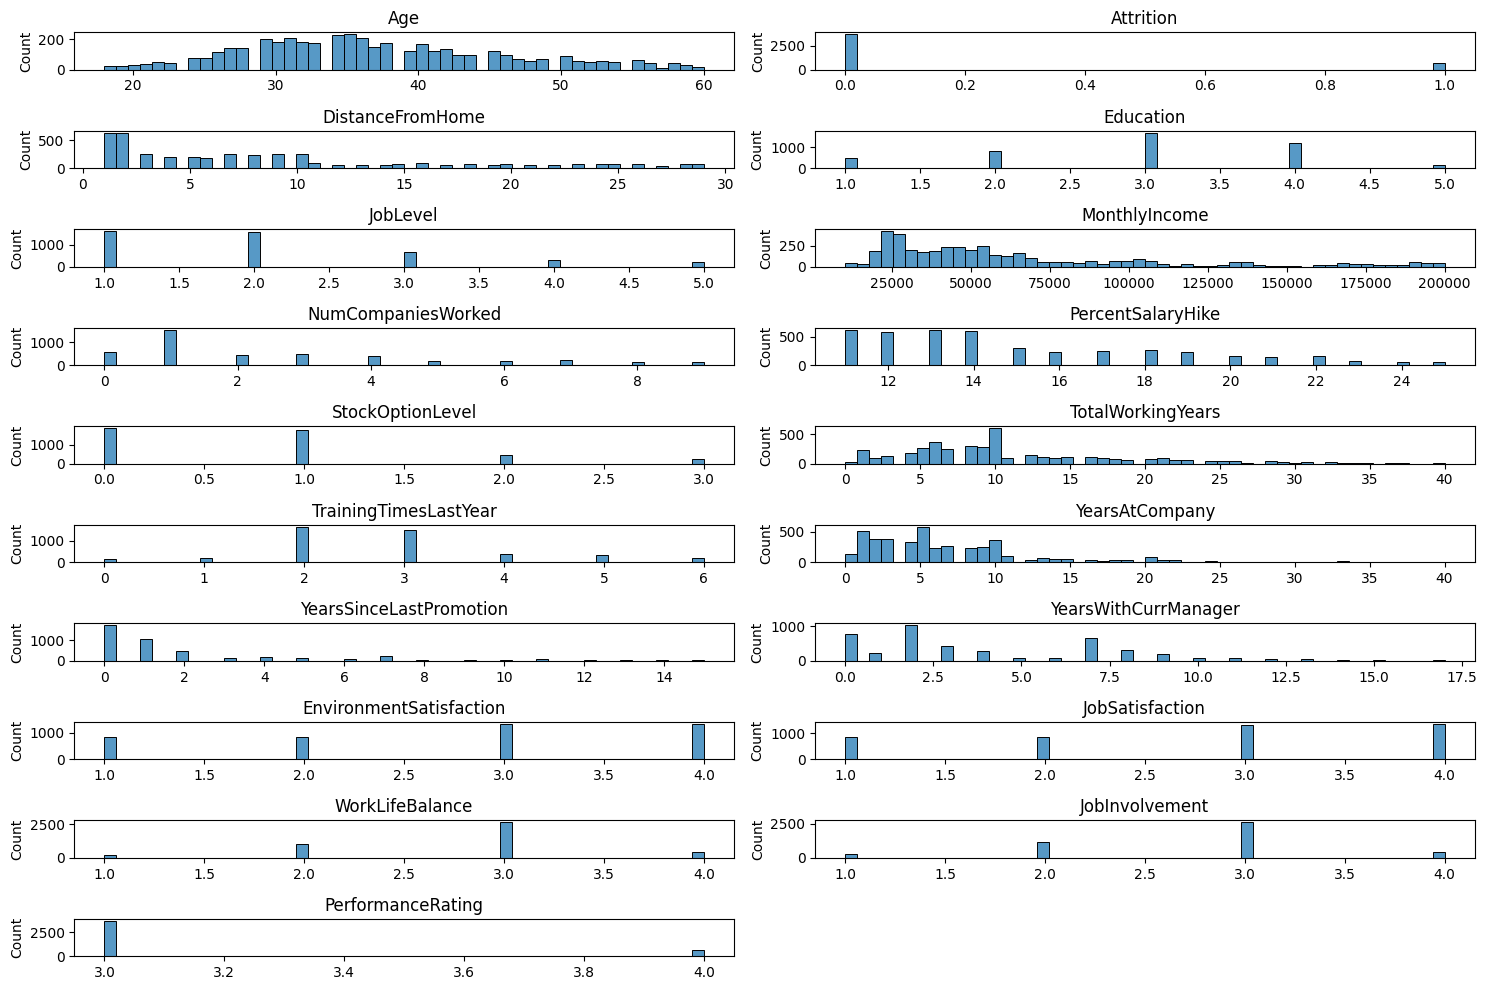

In [473]:
f.plot_numericas(df_num, figsize=(15,10))

Con esta visualización puedo comprobar la distribución de mis variables. De igual forma, veo cuáles corresponden mejor a variables categóricas.

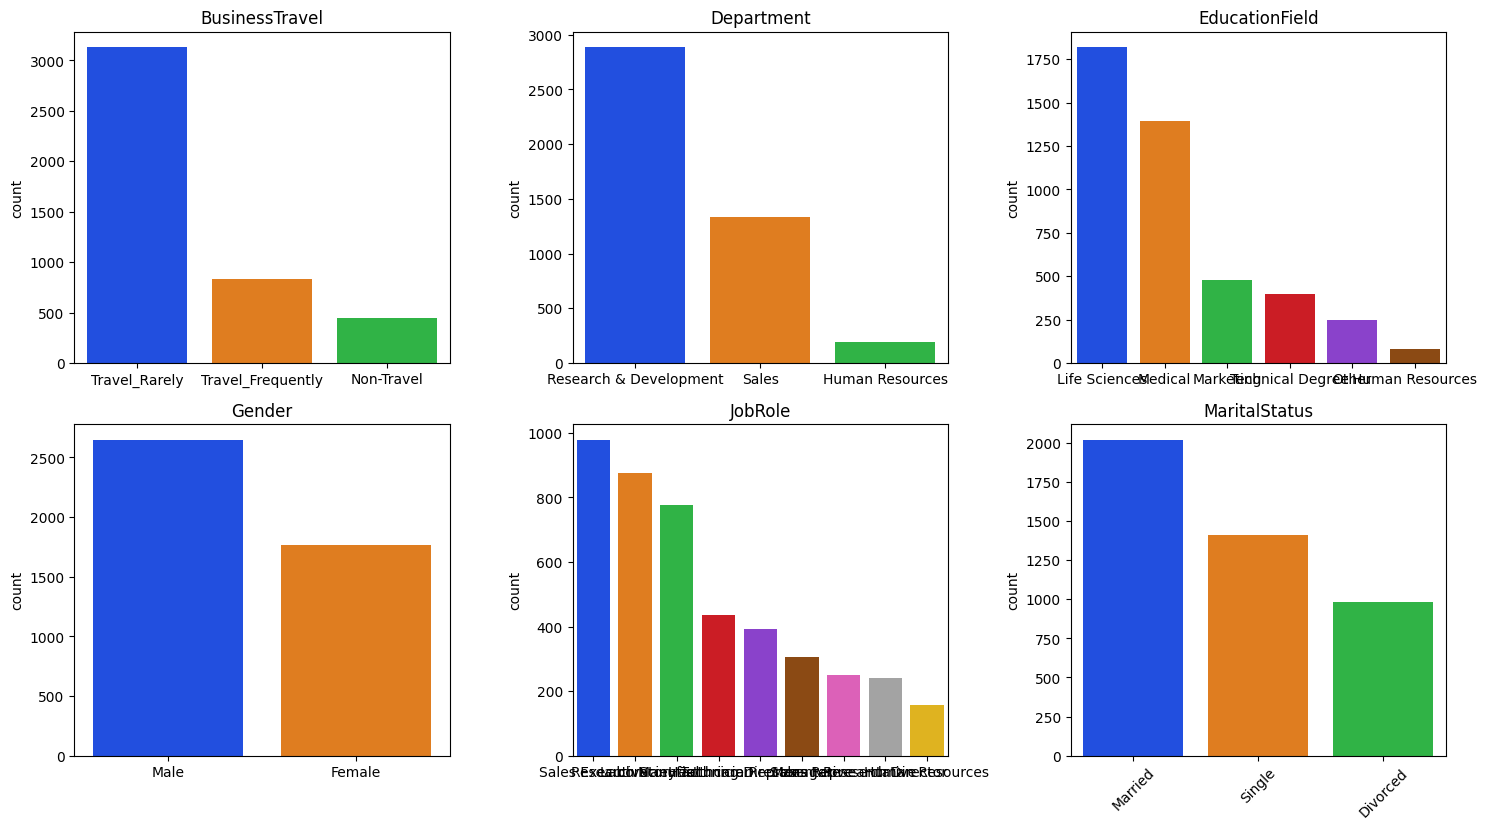

In [461]:
f.plot_categoricas(df_cat)

Con relación a mis variables categóricas, aquí puedo ver el conteo de sus categorías desde la que más presencia tiene hasta la de menor presencia.

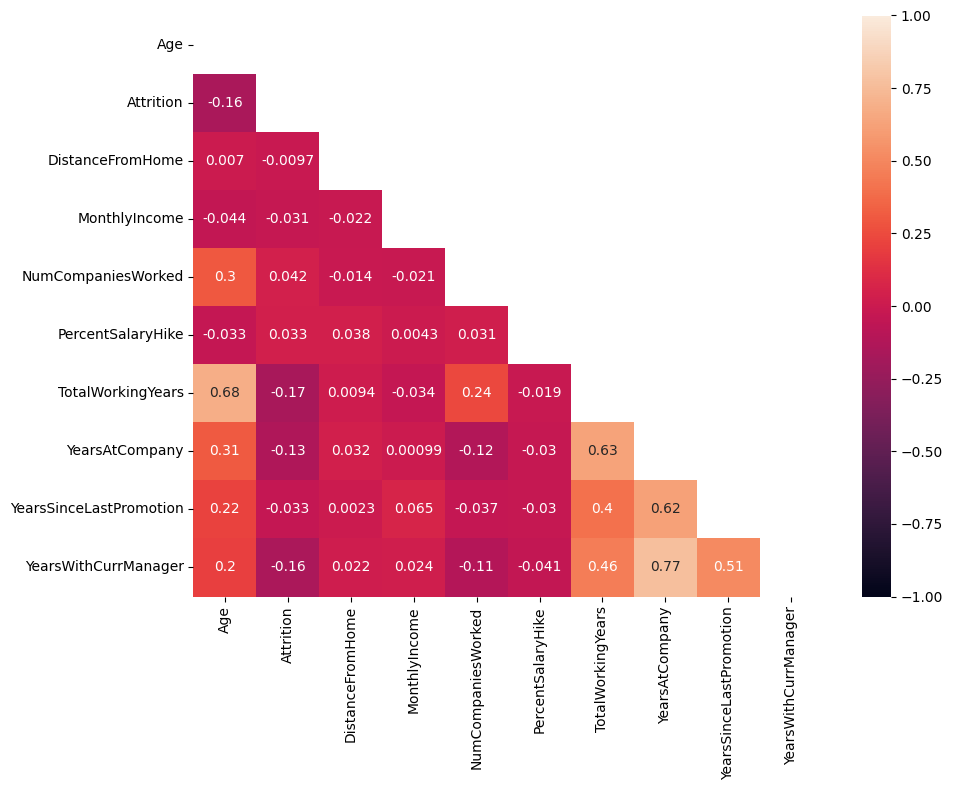

In [462]:
f.matriz_correlacion(df_mergeo, figsize=(10,8))

## Observaciones respecto a las correlaciones: 
- Se observa una correlación positiva entre los años de trabajo y la edad (0.68). Tiene sentido que se relacionen ya que estas pueden tener mucha congruencia.
- Los años en la compañía y el tiempo de trabajo también presentan una correlación positiva (0.63). Representa una relación lógica en el ámbito laboral.
- El tiempo en la compañía y los años bajo el mismo manager también presentan una alta correlación (0.77). Esta, por igual, tiene mucho sentido a la hora de una buena relación laboral. Si esto es positivo normalmente arroja un buen trabajo de los gerentes o supervisores.

### Llamada a la clase del src

In [463]:
visuales = spp.Visualizador(df_mergeo)

BusinessTravel
Department
Education
EducationField
Gender
JobLevel
JobRole
MaritalStatus
StockOptionLevel
TrainingTimesLastYear
EnvironmentSatisfaction
JobSatisfaction
WorkLifeBalance
JobInvolvement
PerformanceRating


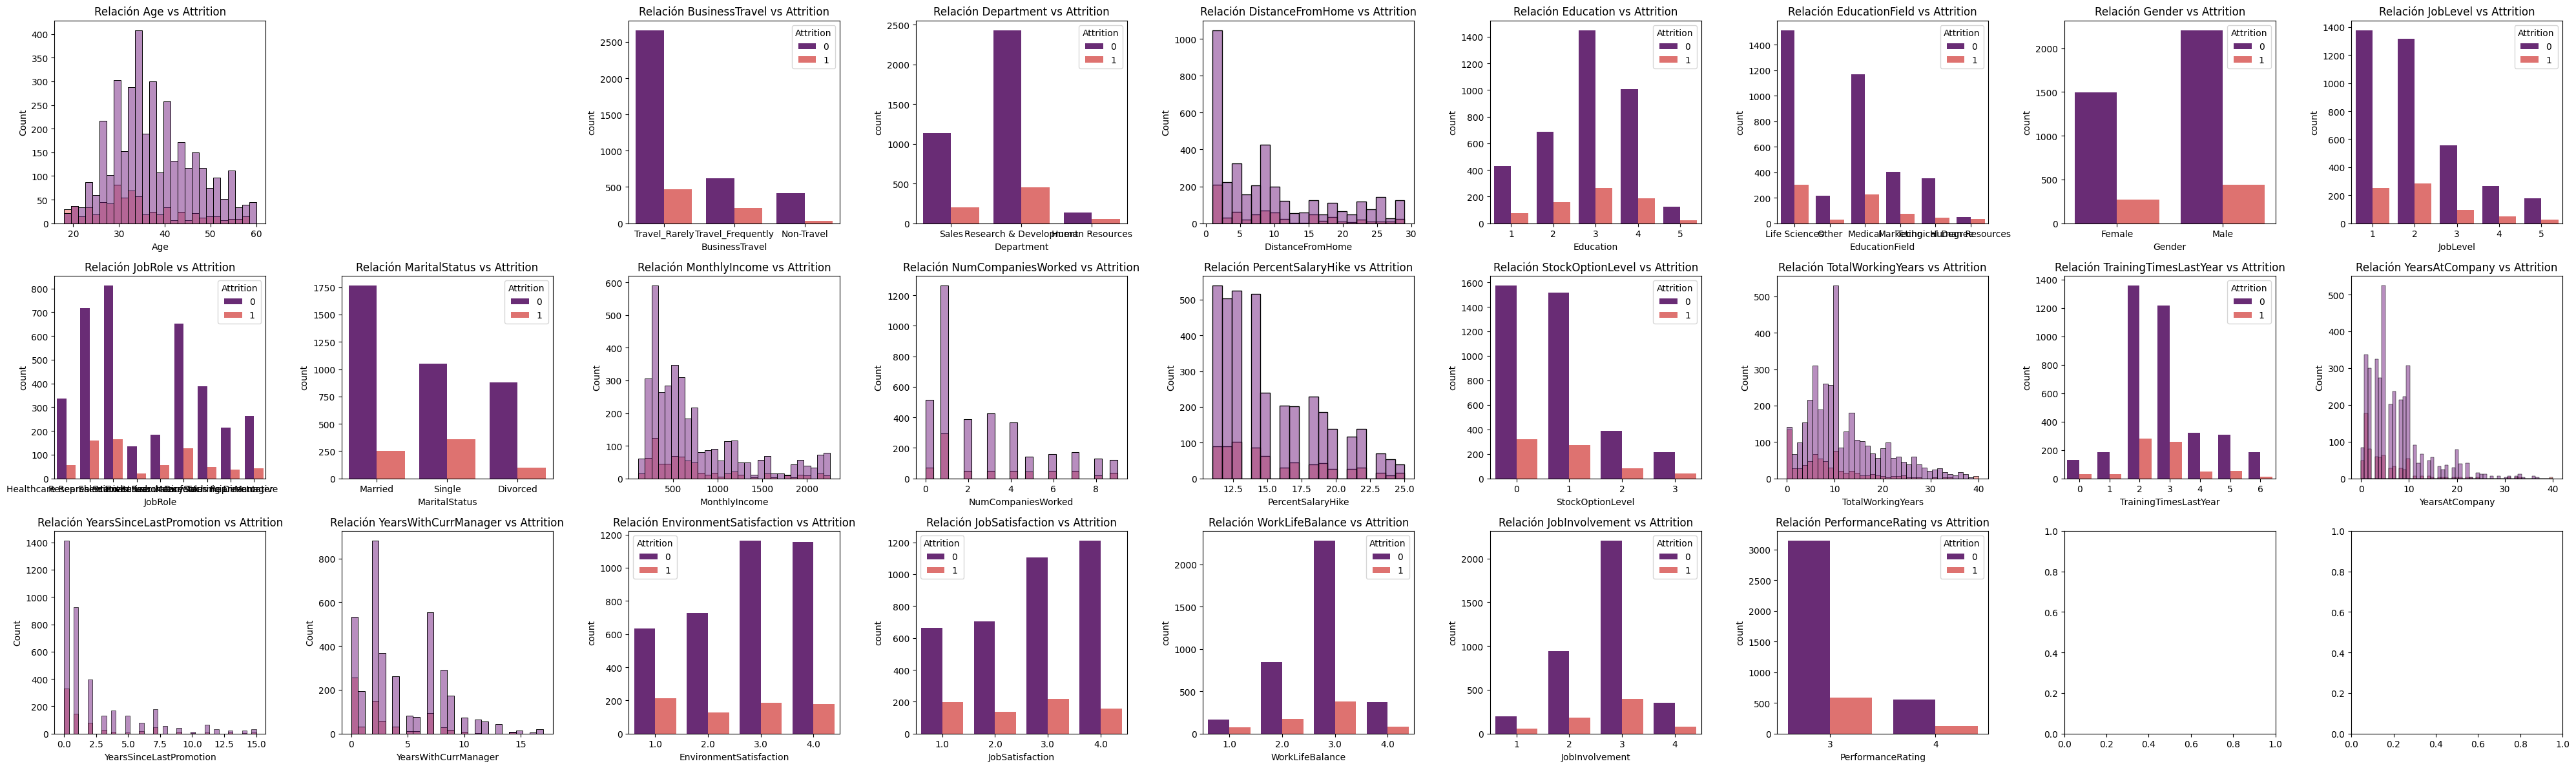

In [475]:
visuales.plot_relacion('Attrition')

## Relaciones VR con variables numéricas

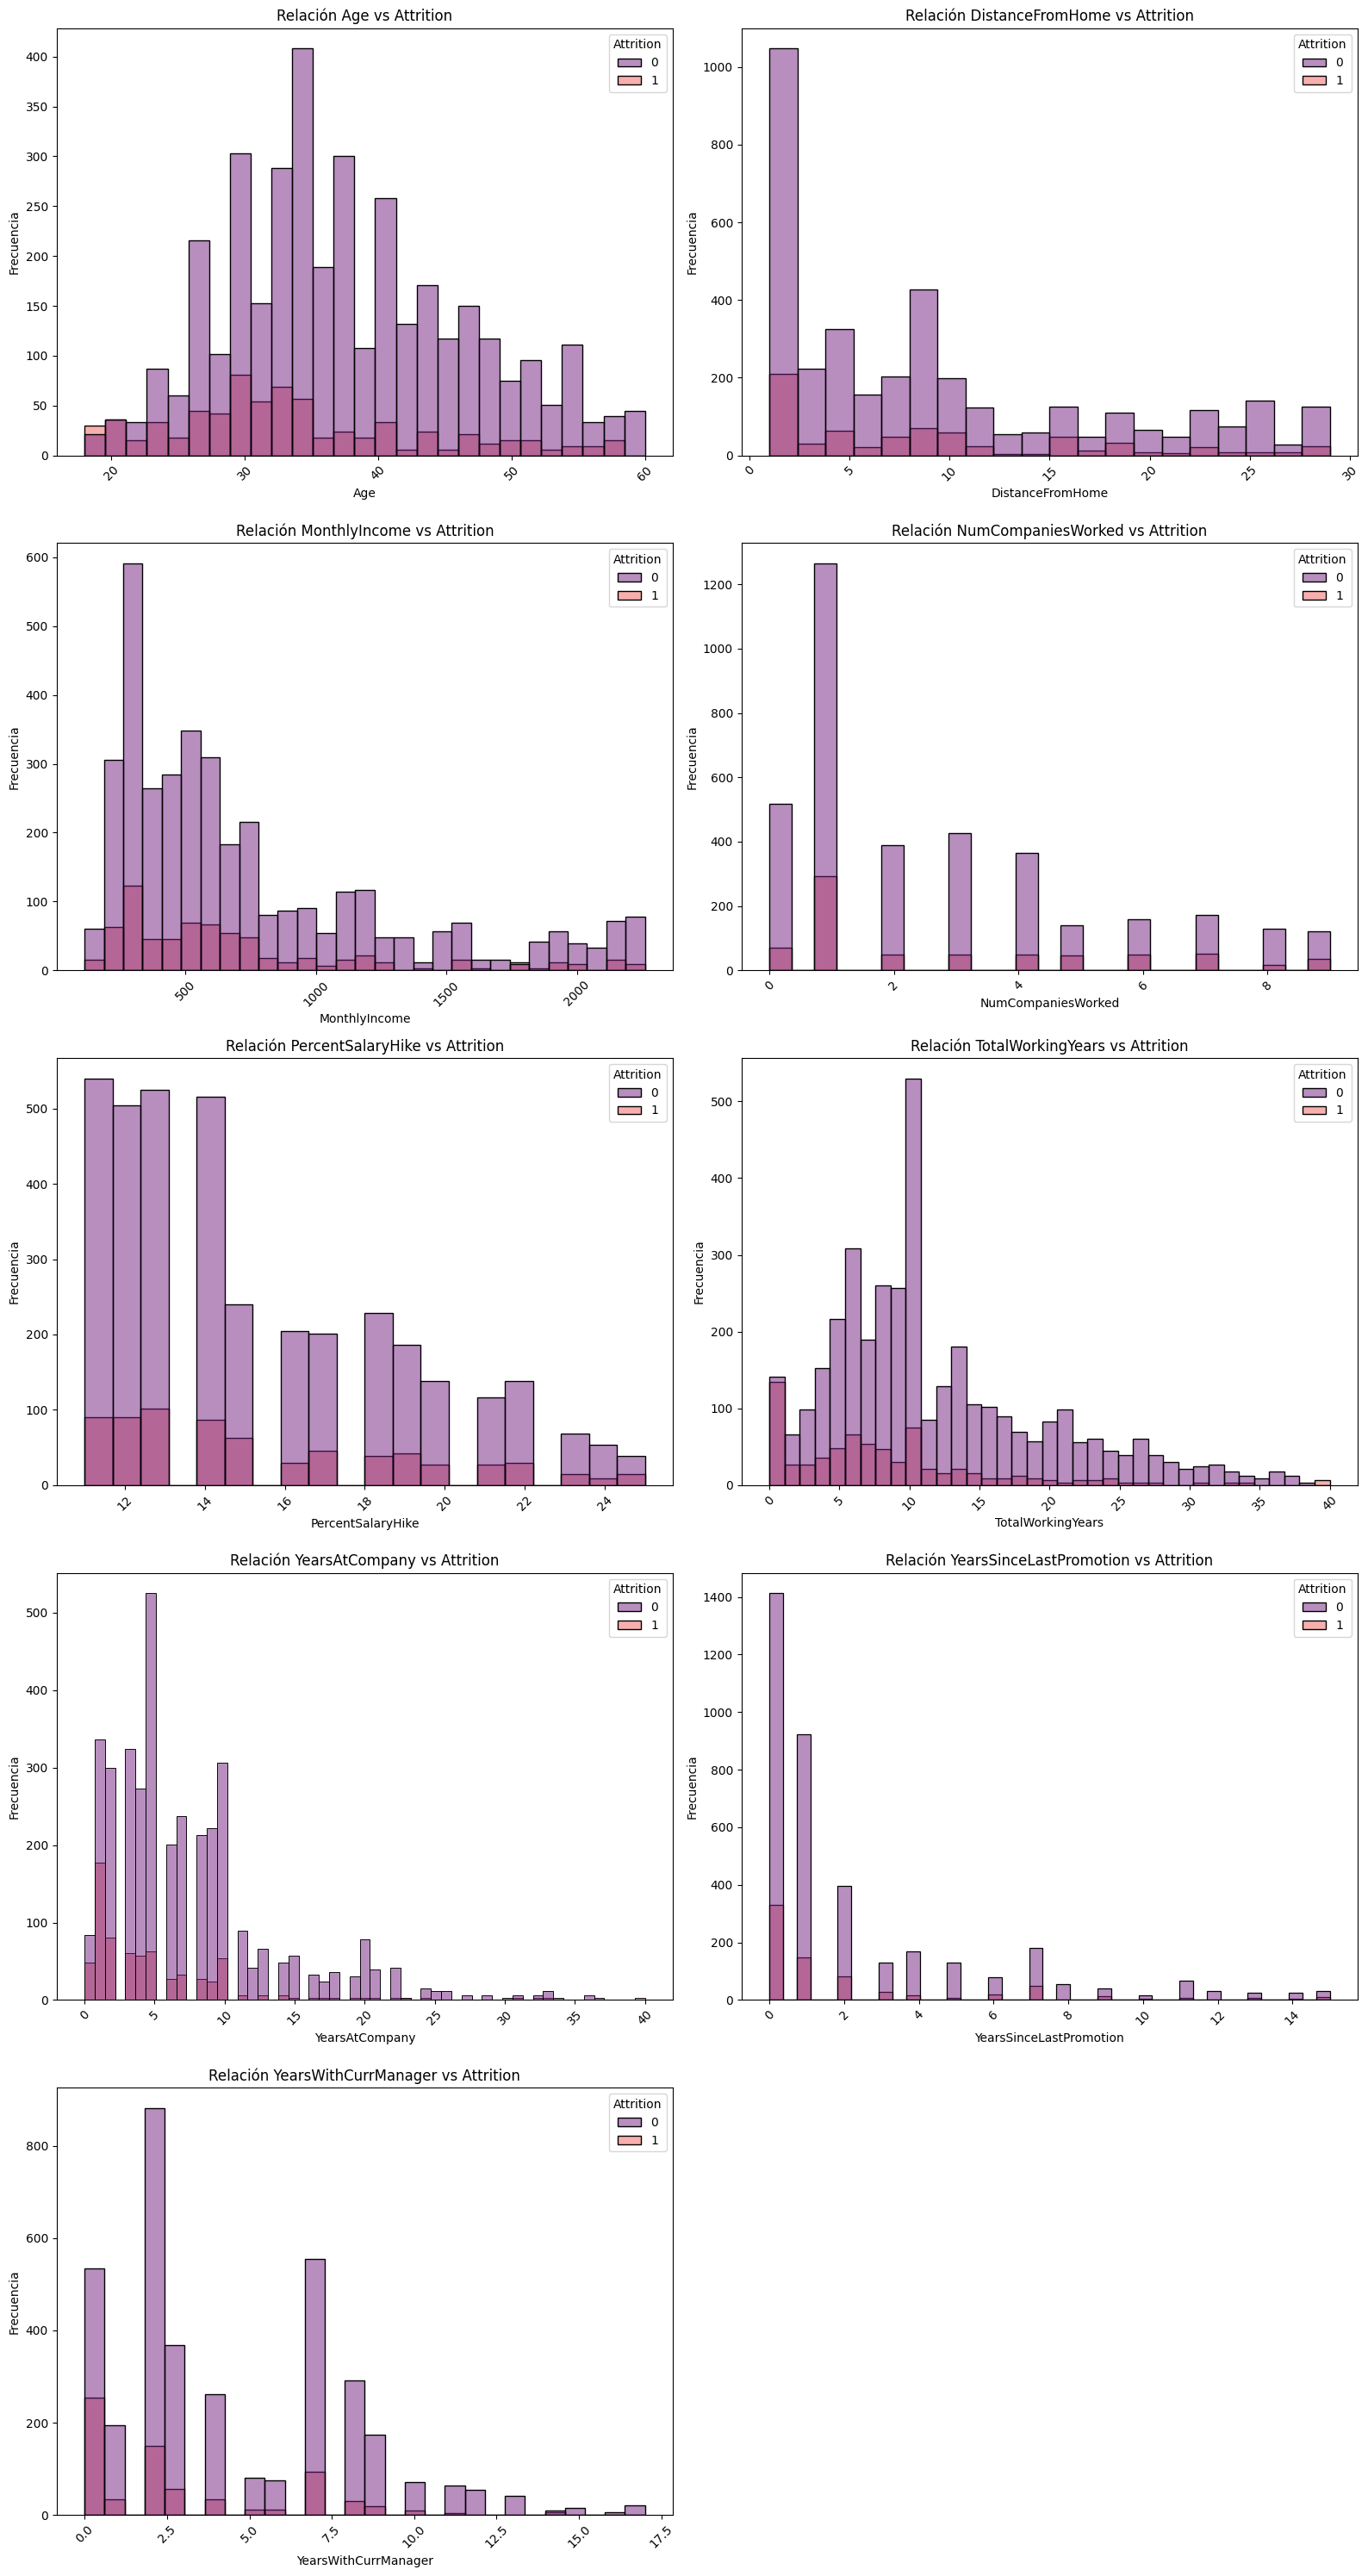

In [474]:
f.graficar_relaciones_numericas(df_mergeo, 'Attrition')

## Observaciones:
- No existe una presencia alta, o relación significativa que señalar que se pruebe de manera clara. Sin embargo podemos mencionar que:
    - Los más jóvenes, por debajo de 35, son los que tienen un poco más de presencia entre los que se fueron en el último año.
    - Esto también es similar con relación a los salarios, por debajo de los 800 euros es que se ven más salidas.
    - Se ve una relación casi idéntica, 50 vs 50, de permanencia o salida en los empleados de un año de presencia en la compañía. Esto puede indicar que algo pasa durante el primer año.
    - Además, se puede ver que durante el primer año durante un gerente se ven salidas pero que a medida que pasa el tiempo durante el mismo gerente estas salidas se ven disminuidas.

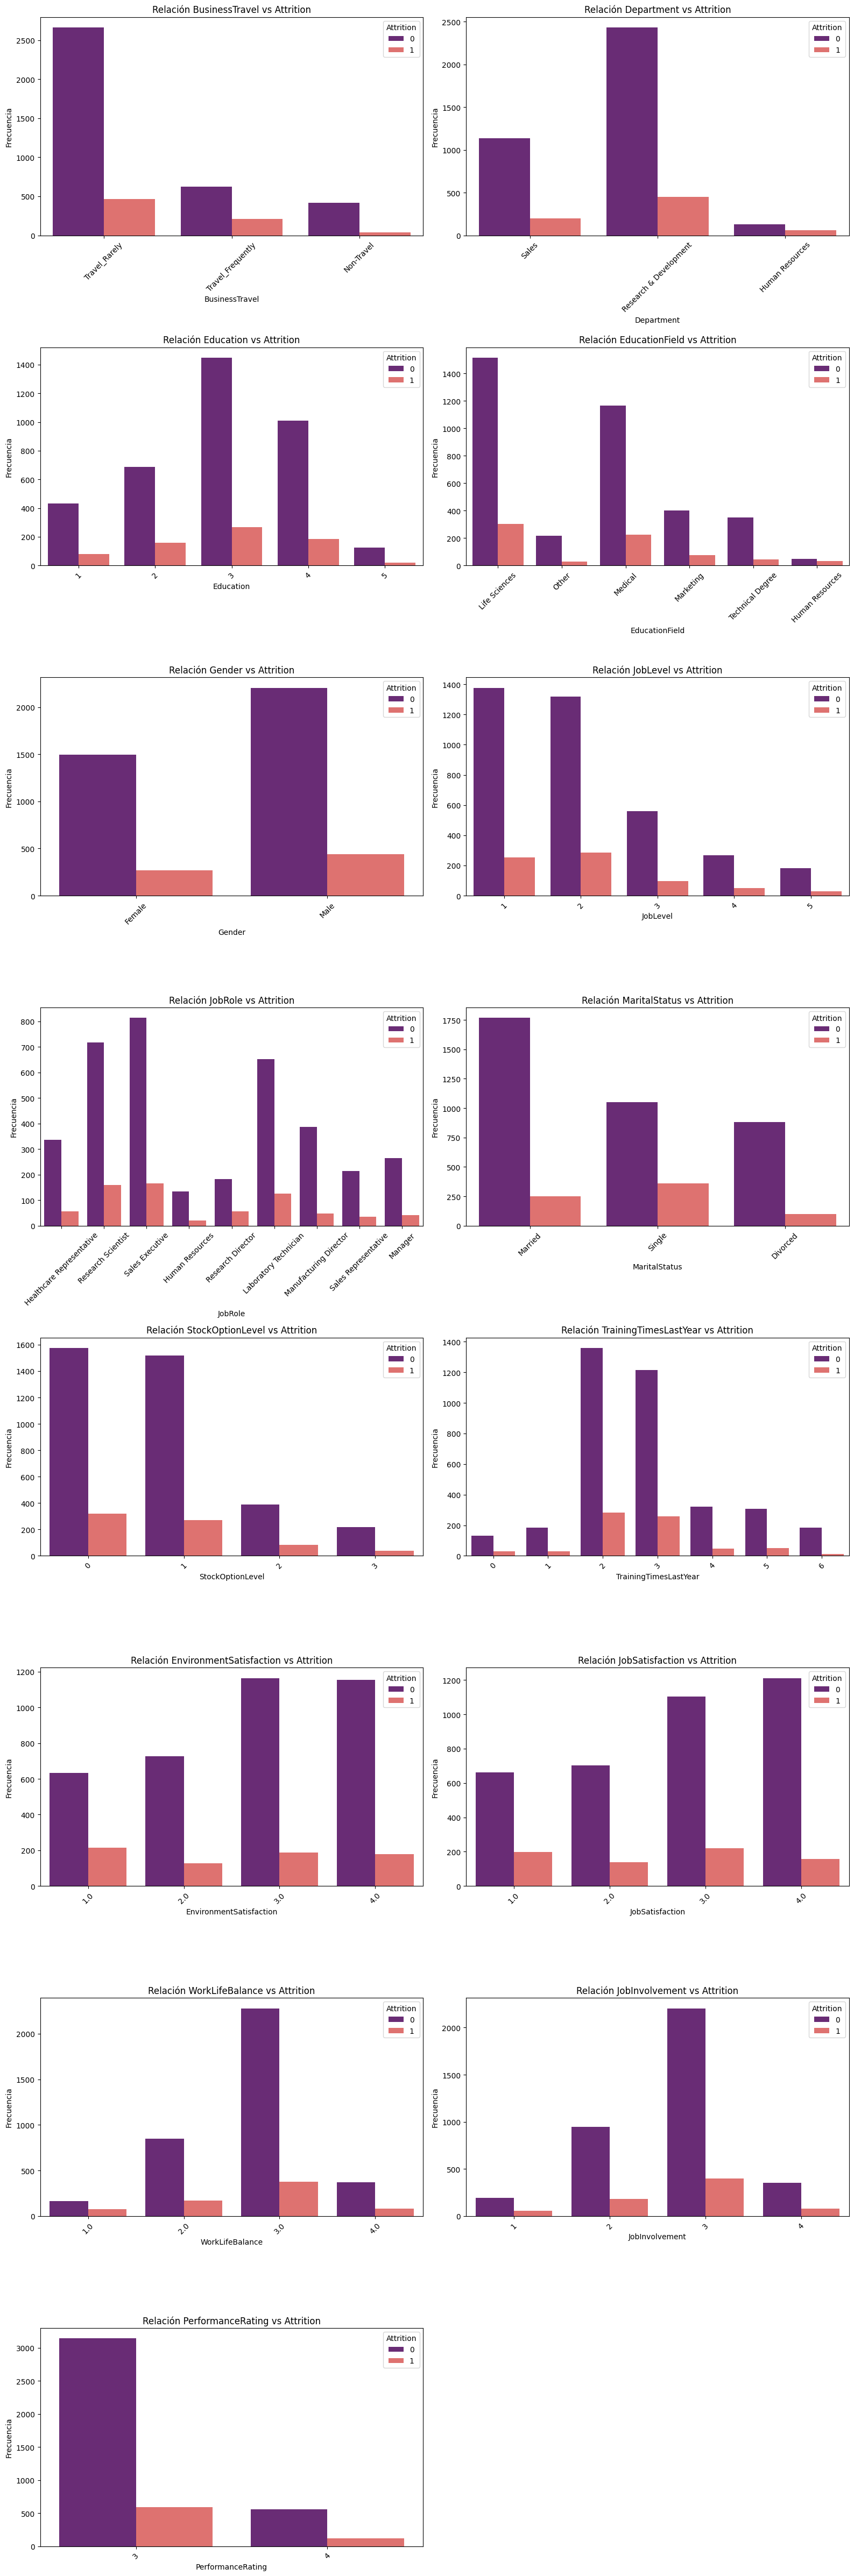

In [467]:
f.graficar_relaciones_categoricas(df_mergeo,'Attrition')

- Se puede observar casi una distribución normal en la relación de Education con Attrition. En los niveles más bajos se ve un aumento en la salida, al llegar al nivel intermedio está el pico más alto pero luego empieza a bajar.
- Los hombres son los que tienen más salida, aunque también hay que considerar que tienen más presencia en la compañía.
- Hay más salidas en el último año para los puestos de un nivel más bajos. Que a la vez se traduce en que a medida que se aumenta el nivel en la empresa, es menos común la salida de estos puestos.
- En la satisfacción del ambiente laboral y la satisfacción con el trabajo, no se presencia ninguna alerta como tal que se señale para todos. Incluso aquellos que no están 'muy contentos' (nivel 2) son el grupo con menos salida en el último año.
- En cuanto al balance vida-trabajo, el grupo que está en un nivel 3 ('Better') es el que ha sufrido más salidas en el último año.
- En cuanto al performanceRating, aquellos con una calificación de 'Excellent' por parte de su supervisor son el grupo con mayor salida.

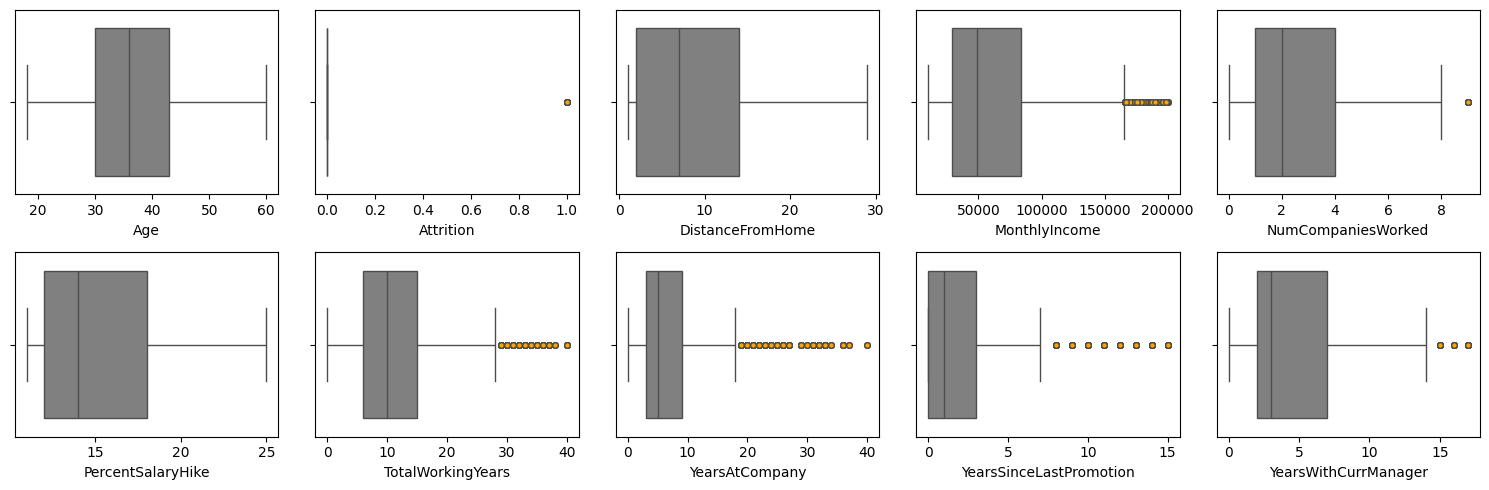

In [468]:
visuales.deteccion_outliers()

In [469]:
tasa_de_cambio = 0.0113

df_mergeo['MonthlyIncome'] = df_mergeo['MonthlyIncome'].apply(lambda x: x * tasa_de_cambio)

## Imputar nulos

Mis nulos están en las siguientes columnas: NumCompaniesWorked, EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance. Sin embargo, solo una de ellas es numérica (NumCompaniesWorked).

In [470]:
df_mergeo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Age                      4410 non-null   int64   
 1   Attrition                4410 non-null   int64   
 2   BusinessTravel           4410 non-null   object  
 3   Department               4410 non-null   object  
 4   DistanceFromHome         4410 non-null   int64   
 5   Education                4410 non-null   category
 6   EducationField           4410 non-null   object  
 7   Gender                   4410 non-null   object  
 8   JobLevel                 4410 non-null   category
 9   JobRole                  4410 non-null   object  
 10  MaritalStatus            4410 non-null   object  
 11  MonthlyIncome            4410 non-null   float64 
 12  NumCompaniesWorked       4391 non-null   float64 
 13  PercentSalaryHike        4410 non-null   int64   
 14  StockOpt

In [471]:
df_mergeo['EnvironmentSatisfaction'] = df_mergeo['EnvironmentSatisfaction'].fillna('Desconocido')
df_mergeo['JobSatisfaction'] = df_mergeo['JobSatisfaction'].fillna('Desconocido')
df_mergeo['WorkLifeBalance'] = df_mergeo['WorkLifeBalance'].fillna('Desconocido')
df_mergeo['WorkLifeBalance'] = df_mergeo['WorkLifeBalance'].fillna('Desconocido')

TypeError: Cannot setitem on a Categorical with a new category (Desconocido), set the categories first

In [ ]:
df_mergeo.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
EnvironmentSatisfaction     0
JobSatisfaction             0
WorkLifeBalance             0
JobInvolvement              0
PerformanceRating           0
dtype: int64

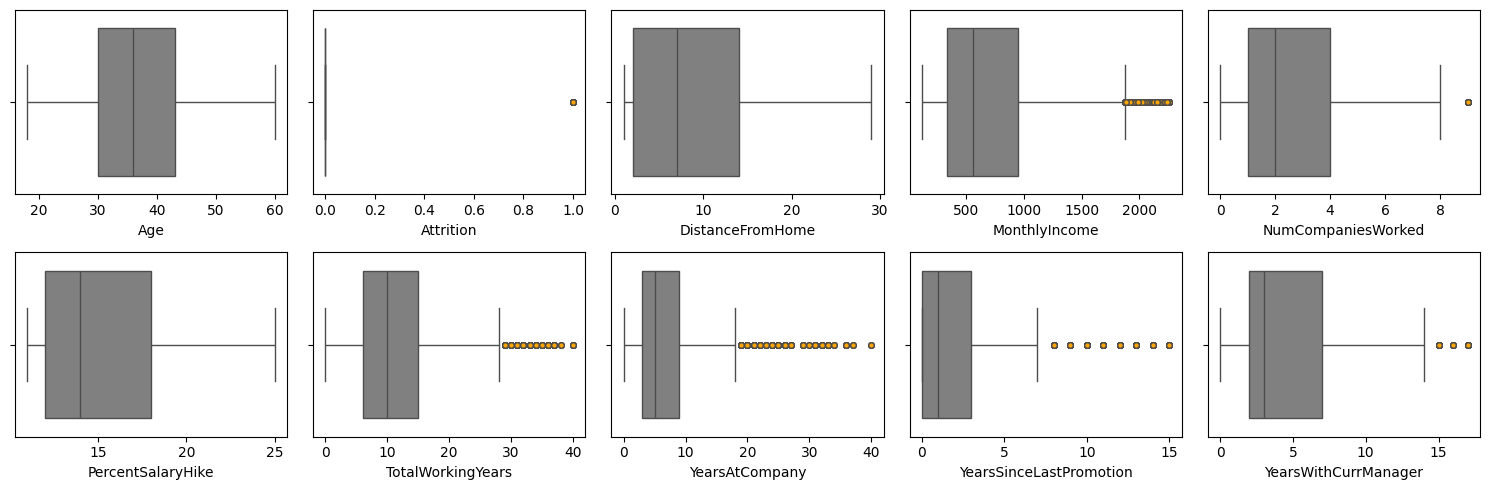

In [ ]:
visuales.deteccion_outliers()

In [ ]:
df_mergeo.describe()

,Age,Attrition,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,4410.000000,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,4401.000000,4410.000000,4410.000000,4410.000000
mean,36.923810,0.161224,9.192517,734.831236,2.694830,15.209524,11.279936,7.008163,2.187755,4.123129
std,9.133301,0.367780,8.105026,531.878441,2.498887,3.659108,7.782222,6.125135,3.221699,3.567327
min,18.000000,0.000000,1.000000,114.017000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,2.000000,328.943000,1.000000,12.000000,6.000000,3.000000,0.000000,2.000000
50%,36.000000,0.000000,7.000000,555.847000,2.000000,14.000000,10.000000,5.000000,1.000000,3.000000
75%,43.000000,0.000000,14.000000,946.940000,4.000000,18.000000,15.000000,9.000000,3.000000,7.000000
max,60.000000,1.000000,29.000000,2259.887000,9.000000,25.000000,40.000000,40.000000,15.000000,17.000000


In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# simple imputer
# df_num.drop(columns='Attrition', inplace=True)
imputer = IterativeImputer(estimator=DecisionTreeClassifier(), max_iter=10, random_state=42) #busca 5 vecinos para completarse, por defecto 5
it_imputados = imputer.fit_transform(X=df_num) #relleno mis nulos
df_num_sin_nulos = pd.DataFrame(it_imputados, columns= df_num.columns)
df_ = df_mergeo.copy() 
df_[df_num.columns] = df_num_sin_nulos # mi df sin nulos, le pongo los datos en df_knn, en las columnas numericas (esta en corchetes)
df_.isna().sum() #verifico que no tengo nulos en las numéricas

Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
PercentSalaryHike          0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
JobInvolvement             0
PerformanceRating          0
EmployeeID                 0
dtype: int64

In [ ]:
df_['NumCompaniesWorked'].value_counts()

NumCompaniesWorked
1.0    1563
0.0     591
3.0     477
2.0     438
4.0     417
7.0     222
6.0     210
5.0     189
9.0     156
8.0     147
Name: count, dtype: int64

## Desbalanceo

In [ ]:
df_mergeo['Attrition'].value_counts(normalize=True) * 100

Attrition
0    83.877551
1    16.122449
Name: proportion, dtype: float64